In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as sp

In [3]:
df=pd.read_csv('stats/stat_audio_features.txt',index_col='track_id')
df.head()

,danceability,energy,key,loudness,mode,valence,tempo,duration_ms,time_signature
track_id,,,,,,,,,
1AG0zqRn0lKTXDqcnXKa1x,0.765,0.860,1,-8.391,1,0.381,129.061,321800,4
7EovTzlTgRD6MdprArq80m,0.768,0.985,1,-7.353,0,0.890,143.975,310185,4
6G7OiVdHJAbsaNqx94ojqg,0.808,0.831,0,-5.855,0,0.376,135.976,262827,4
5CzBAxZkcYP3YMKOKtTKhe,0.366,0.519,6,-13.202,0,0.446,131.948,305455,4
6M3BYtzp1WLov2NDM5nsaI,0.584,0.462,1,-14.445,1,0.366,127.028,183360,4


In [4]:
def minute_seconds(x) : 
    rounded = round(x/1000)
    minutes = rounded//60
    seconds = rounded%60
    return 

df['duration_seconds']=round(df['duration_ms']/1000)

<AxesSubplot: xlabel='key', ylabel='count'>

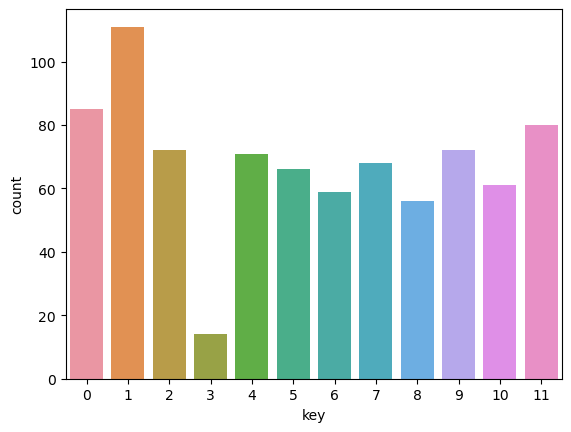

In [5]:
sns.countplot(data=df,x='key')

Key is defined by the Pitch Class Notation. https://en.wikipedia.org/wiki/Pitch_class
where 0 is the key of C, 1 is C# and so on .
Interessingly, the most occuring key is not C but C#.
The least occuring key is the key of D# / E flat

<AxesSubplot: xlabel='time_signature', ylabel='count'>

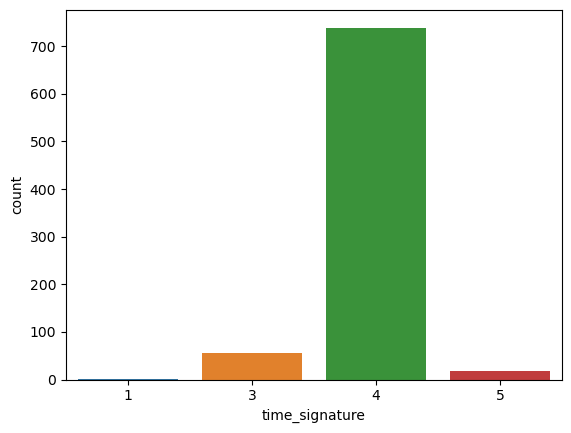

In [6]:
sns.countplot(data=df,x='time_signature')

what genre are associated of 5/4? is it accurate?
same question for 3/4

<AxesSubplot: xlabel='duration_seconds'>

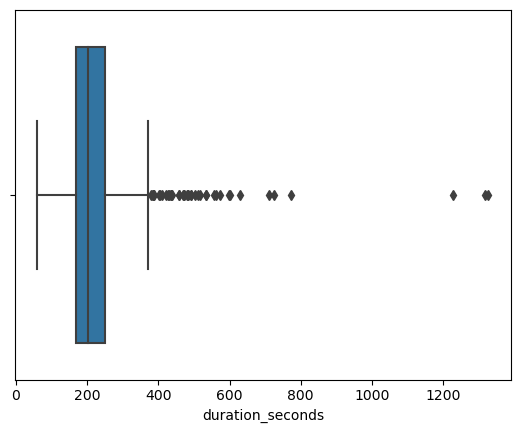

In [7]:
sns.boxplot(data=df,x='duration_seconds')

<AxesSubplot: >

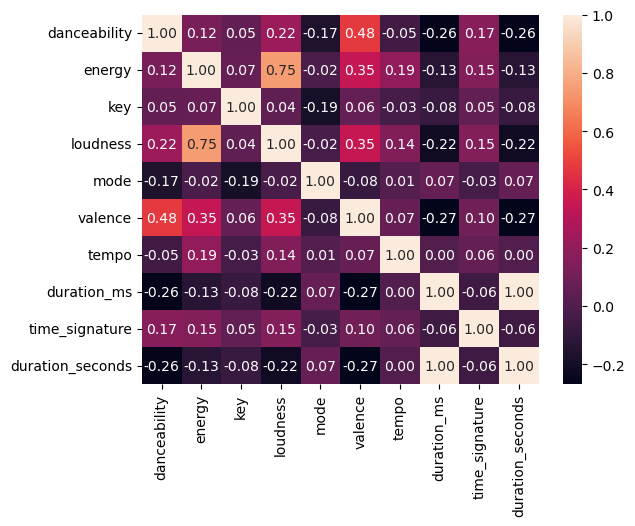

In [8]:
sns.heatmap(data=df.corr(),annot=True,fmt='.2f')

In [9]:
df_temp = df[df['time_signature']==5]
df_temp.head()

,danceability,energy,key,loudness,mode,valence,tempo,duration_ms,time_signature,duration_seconds
track_id,,,,,,,,,,
04Blc3wPUReZEVymBvn30i,0.415,0.708,1,-10.456,1,0.344,109.197,195139,5,195.0
4d7BPCLKQxZCr4ZzKhZzpB,0.226,0.785,6,-8.011,1,0.302,173.315,562329,5,562.0
2y8H9S10QJxh50QPg7ZR7r,0.374,0.176,7,-9.342,0,0.121,78.161,229625,5,230.0
4Om70ABodx5bhfnXW6150J,0.445,0.925,8,-3.229,0,0.515,86.466,126431,5,126.0
3X2xKuavDwk7I5B5XIxPWS,0.609,0.618,11,-6.573,0,0.364,123.682,189670,5,190.0


In [10]:
px.box(df,x='duration_seconds') 

NameError: name 'px' is not defined

La durée des morceaux ne semble pas suivre une loi normale

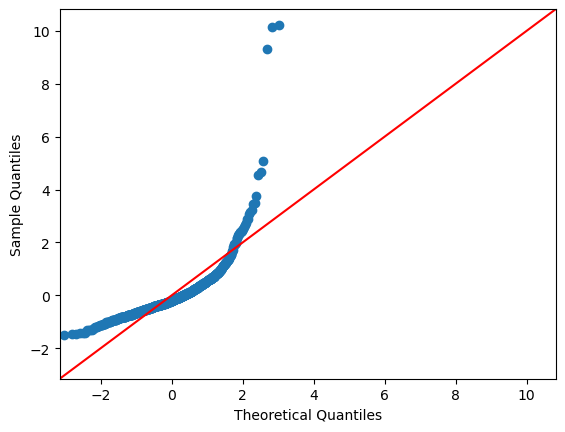

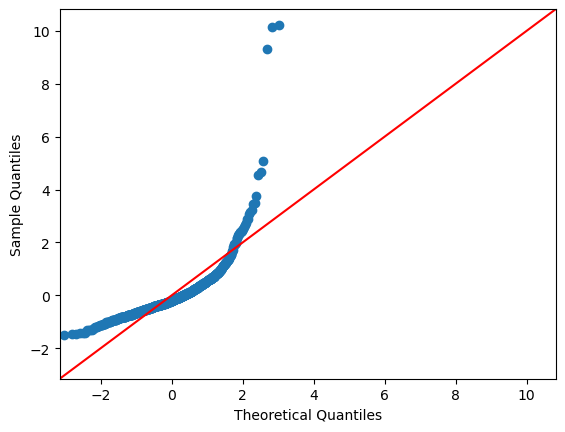

In [11]:
sm.qqplot(df['duration_seconds'], fit = True, line = '45') 

le tempo semble suivre une loi normale

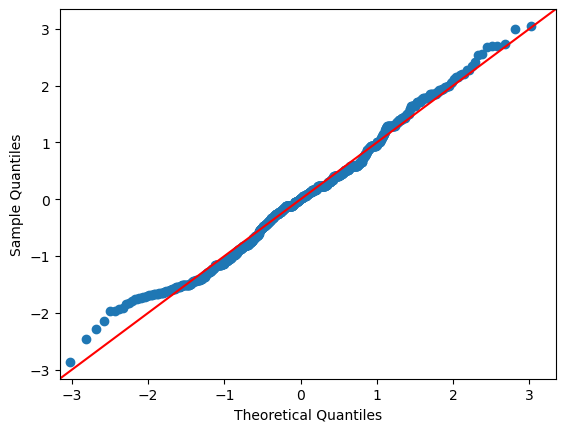

In [12]:
sm.qqplot(df['tempo'], fit = True, line = '45');

In [13]:
df.describe()

,danceability,energy,key,loudness,mode,valence,tempo,duration_ms,time_signature,duration_seconds
count,815.000000,815.000000,815.000000,815.000000,815.000000,815.00000,815.000000,8.150000e+02,815.000000,815.000000
mean,0.582971,0.655500,5.309202,-7.830535,0.631902,0.46397,123.182123,2.232988e+05,3.946012,223.282209
std,0.186586,0.215563,3.674415,3.506464,0.482584,0.24683,28.490704,1.079524e+05,0.331819,107.946098
min,0.069300,0.035500,0.000000,-29.477000,0.000000,0.02790,41.629000,5.988900e+04,1.000000,60.000000
25%,0.457000,0.511500,2.000000,-9.348500,0.000000,0.26450,101.077000,1.682630e+05,4.000000,168.000000
50%,0.602000,0.695000,5.000000,-7.192000,1.000000,0.44500,123.682000,2.020550e+05,4.000000,202.000000
75%,0.725000,0.821500,9.000000,-5.504000,1.000000,0.64900,139.925000,2.505950e+05,4.000000,250.500000
max,0.971000,0.995000,11.000000,-0.622000,1.000000,0.97200,210.089000,1.327375e+06,5.000000,1327.000000


In [14]:
correl,p_value_pearson = sp.pearsonr(df['loudness'],df['danceability'])
print(correl,p_value_pearson)

0.22415068129954172 9.684065417514163e-11
